# MIS 583 Assignment 3: Semi-supervised Flower Classfication

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 陳昱逢, B092040016.

## Semi-supervised Flower Classfication

In this approach, you have a dataset that includes both labeled and unlabeled examples.

The goal is to use the labeled data to train the model while also leveraging the unlabeled
data to improve the model's performance.

In this assignment, you’ll explore a self-training mechanism for this task.


**Please note that you’re not allowed to use pre-constructed models or pre-trained weights.**

## Kaggle Competition
Kaggle is an online community of data scientists and machine learning practitioners. Kaggle allows users to find and publish datasets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

This assignment use kaggle to calculate your grade.  
Please use this [**LINK**](https://www.kaggle.com/t/e304bb12c8a84e5c9c1b27a6c3bd4026) to join the competition.

**Again, Use your SID as your team's name!!!**

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

We use `python==3.10.12`, `torch==2.0.1+cu118` and `torchvision==0.15.2+cu118`. This is the default version in Google Colab.

In [2]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
torch 2.1.0+cu118
torchvision 0.16.0+cu118


# Prepare Data

We use [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset.
This is collected by Alexander Mamaev.

**Abstrct**  

We clean the dataset,this dataset contains 4262 flower images.   
**IMPORTANT: you CANNOT use any extra images.**

The data collection is grabed from the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.

The pictures are divided into five classes:
+ daisy
+ tulip
+ rose
+ sunflower
+ dandelion

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## How to Get Data

請先到共用雲端硬碟將檔案 `A3_data_flower_2023.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1eme754s_uI5dI5SnNUH2ZuvJ5QT-kmaZ/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

## Unzip Data

Unzip `A3_data_flower_2023.zip`, there are 2 folders and 4 csvs.

- `train/`: contains 5 folders for 5 categories of flowers. Images of flowers inside them.
- `test/`: unclassified images of testing set.
- `train_labeled_dataset.csv`: file path and true label of training set.
- `train_unlabeled_dataset.csv`: file path and without label of training set.
- `val.csv`: file path and true label of validation set.
- `test.csv`: file paht of testing set.

There are **843 images in labeled_dataset_train.**  

There are **1713 images in unlabeled_dataset_train.**

There are **853 images in dataset_test.**  

There are **853 images in dataset_val.**  

---

解壓縮 `A3_data_flower_2023.zip` 後可以發現裡面有兩個資料夾和四個csv檔。

+ `train` : 存有五個資料夾分別是五個種類的花，資料夾內為花的照片。
+ `test` : 資料夾中為未分類之測試集照片。
+ `train_labeled_dataset.csv` : 讀取 train data 的順序、路徑與圖片所屬花別。
+ `train_unlabeled_dataset.csv` : 讀取 train data 的順序、路徑與圖片但沒有所屬花別標籤。
+ `val.csv` : 讀取 validate data 的順序、路徑與圖片所屬花別。
+ `test.csv` : 讀取 test data 的順序、路徑。

其中`train_labeled`的圖片 843 張，`train_unlabeled`的圖片 1713 張，`val` 的圖片 853 張，`test` 的圖片 853 張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [3]:
!unzip -qq ./drive/MyDrive/A3_data_flower_2023.zip

In [4]:
data_folder = 'A3_data_flower_2023'

## Loading the dataset

### Custom dataset

Build a classs inherit `torch.utils.data.Dataset`.  
Implement `__init__`, `__getitem__` and `__len__` 3 functions.  

Some operations could be there: setting location of dataset, the method of reading data, label of dataset or transform of dataset.

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

---

繼承自定義資料集的框架 `torch.utils.data.Dataset`，主要實現 `__getitem__()` 和 `__len__()` 這兩個方法。

常使用來做到設定資料位址、設定讀取方式、子資料集的標籤和轉換條件...等。

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

### Data augmentation

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

PyTorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/vision/stable/transforms.html)

**NOTICE**: There are some operations may not be necessary for predict, so we should write one for train and one for others.

In [5]:
import csv
import os
import numpy as np
from PIL import Image
import torch

class FlowerData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.labels = []
        self.transform = transform

        with open(f'{data_folder}/{csv_file}', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(f"{data_folder}/{row['file_path']}")
                if mode != 'test':
                    self.labels.append(row['label'])

    def __getitem__(self, index):
        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        label = int(self.labels[index])

        return data, label

    def __len__(self):
        return len(self.data_list)

In [6]:
from torchvision import transforms
from torchvision.transforms import v2
# For TRAIN
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for training, find the composition to get better result #
########################################################################
transforms_train = v2.Compose([
    v2.RandomResizedCrop(224, scale=(0.8,1.0)),
    v2.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(15),
    #v2.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.2),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.Resize((224,224))
])
########################################################################
#                           End of your code                           #
########################################################################

# For VAL, TEST
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for validate and test,                                  #
#  NOTICE some operation we usually not use in this part               #
########################################################################
transforms_test = v2.Compose([
    #v2.CenterCrop(224),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.Resize((224,224))
])
########################################################################
#                           End of your code                           #
########################################################################

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


### Instantiate dataset

Let's instantiate three `FlowerData` class.
+ train_set: for labeled_training.
+ unlabeled_set: for unlabeled_training.
+ dataset_val: for validation.

In [7]:
train_set = FlowerData('train_labeled_dataset.csv', mode='train', transform=transforms_train)
unlabeled_set = FlowerData('train_unlabeled_dataset.csv', mode='test', transform=transforms_train)
valid_set = FlowerData('val.csv', mode='val', transform=transforms_test)

In [8]:
print("The first image's shape in dataset_train :", train_set[0][0].size())
print("There are", len(train_set), "images in labeled_dataset_train.")
print("There are", len(unlabeled_set), "images in unlabeled_dataset_train.")
print("There are", len(valid_set), "images in dataset_val.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 843 images in labeled_dataset_train.
There are 1713 images in unlabeled_dataset_train.
There are 853 images in dataset_val.


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [9]:
#####################################################
#            You can adjust batch_size              #
#####################################################
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 0
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)

Finally! We have made all data prepared.  
Let's go develop our model.

# Self-training

## Step 1: Supervised training

### Implement CNN using PyTorch

Try to use labeled data design and train a deep convolutional network from scratch to predict the class label of a flower image.

**Again, the goal of this assignment is for you to test different convolutional structures. You cannot directly use the blocks/architectures of pre-trained models.**

In [10]:
from torch.ao.nn.quantized.modules.batchnorm import BatchNorm2d
from torch.nn.modules.conv import Conv2d
import torch.nn as nn
import torch.nn.functional as F

class YourCNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        ########################################################################
        #     TODO: use nn.xxx method to generate a CNN model part             #
        ########################################################################
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 3,stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,194,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(194),
            nn.ReLU(inplace=True),
        )


        self.conv2 = nn.Sequential(
            nn.Conv2d(194,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.change_channel_1 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=1),
            nn.BatchNorm2d(512)
        )


        self.conv4 = nn.Sequential(
            nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

        self.change_channel_2 = nn.Sequential(
            nn.Conv2d(512,1024,kernel_size=1),
            nn.BatchNorm2d(1024)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(1024,2048,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
        )

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.fc = nn.Sequential(
            nn.Linear(3*3*2048,4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256,64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64,5)
        )


        
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
          x = torch.Tensor(x)
        ########################################################################
        #     TODO: forward your model and get output                          #
        ########################################################################
        out = self.conv1(x)
        out = self.maxpool(out)
        out = self.conv2(out)
        cut1 = out
        cut1 = self.change_channel_1(cut1)
        out = self.conv3(out)
        cut2 = out
        cut2 = self.change_channel_2(cut2)
        out = self.conv4(out+cut1)
        out = self.conv5(out+cut2)
        out = self.maxpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        ########################################################################
        #                           End of your code                           #
        ########################################################################
        return out

In [11]:
device = torch.device('cuda')
# or
# device = torch.device('cpu')

In [12]:
model = YourCNNModel()
model.to(device)
#print(model)

YourCNNModel(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 194, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(194, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(194, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine

We have made our model!  
Next, PyTorch also provide many utility function(loss, optmizer...etc).  
You can define them in one-line.

### Define loss and optimizer

In [13]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)    #optim.Adam(model.parameters(), lr=0.0003,weight_decay=0.0001)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

Hint: [torch.max()](https://pytorch.org/docs/stable/generated/torch.max.html#torch-max) or [torch.argmax()](https://pytorch.org/docs/stable/generated/torch.argmax.html)

In [14]:
def train(input_data, model, criterion, optimizer):
    '''
    Argement:
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    for images, labels in input_data:
        images = images.to(device)
        labels = labels.to(device)

        ########################################################################
        # TODO: Forward, backward and optimize                                 #
        # 1. zero the parameter gradients                                      #
        # 2. process input through the network                                 #
        # 3. compute the loss                                                  #
        # 4. propagate gradients back into the network’s parameters            #
        # 5. Update the weights of the network                                 #
        ########################################################################
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ########################################################################
        #                           End of your code                           #
        ########################################################################


        ########################################################################
        # TODO: Get the counts of correctly classified images                  #
        # 1. get the model predicted result                                    #
        # 2. sum the number of this batch predicted images                     #
        # 3. sum the number of correctly classified                            #
        # 4. save this batch's loss into loss_list                             #
        # dimension of outputs: [batch_size, number of classes]                #
        # Hint 1: use outputs.data to get no auto_grad                         #
        # Hint 2: use torch.max()                                              #
        ########################################################################
        _, predicted = torch.max(outputs, 1)
        total_count += labels.size(0)
        acc_count += (predicted == labels).sum().item()
        loss_list.append(loss.item())
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    # Compute this epoch accuracy and loss
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [15]:
def val(input_data, model, criterion):
    model.eval()

    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for images, labels in input_data:
            images = images.to(device)
            labels = labels.to(device)

            ####################################################################
            # TODO: Get the predicted result and loss                          #
            # 1. process input through the network                             #
            # 2. compute the loss                                              #
            # 3. get the model predicted result                                #
            # 4. get the counts of correctly classified images                 #
            # 5. save this batch's loss into loss_list                         #
            ####################################################################
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total_count += labels.size(0)
            acc_count += (predicted == labels).sum().item()
            loss_list.append(loss.item())
            ####################################################################
            #                         End of your code                         #
            ####################################################################

    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

#### Training in a loop
Call train and test function in a loop.  
Take a break and wait.

In [16]:
################################################################################
#     You can adjust those hyper parameters to loop for max_epochs times       #
################################################################################
max_epochs = 180
log_interval = 5 # print acc and loss in per log_interval time


# import torch.optim.lr_scheduler as lr_scheduler

# warm_up_epochs = 50  # 设定warm-up的epoch数
# target_lr = 0.008  # warm-up結束後的學習率

# # 计算每个epoch的学习率增量
# lr_step = (target_lr - 0.001) / warm_up_epochs
# scheduler = lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.1)
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=30)

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
best_val_acc = 0

torch.cuda.empty_cache()

for epoch in range(1, max_epochs + 1):

    # # # Warm-up phase
    # if epoch <= warm_up_epochs:
    #   new_lr = 0.001 + lr_step * (epoch - 1)
    #   for param_group in optimizer.param_groups:
    #     param_group['lr'] = new_lr
    # else:
    #   # Learning rate scheduler
    #   scheduler.step()



    train_acc, train_loss = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = val(valid_loader, model, criterion)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    torch.cuda.empty_cache()


    scheduler.step(val_acc)

    if val_acc >= best_val_acc:
      best_val_acc = val_acc
      # save your well-trained state_dict of model
      torch.save(model.state_dict(), 'NAME_OF_SUPERVISED_TRAINING_EXPERIMENT.pt')


    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))

################################################################################
#                               End of your code                               #
################################################################################

==================== Epoch 5 ====================
Train Acc: 0.564650 Train Loss: 1.107390
  Val Acc: 0.595545   Val Loss: 1.032900
==================== Epoch 10 ====================
Train Acc: 0.621590 Train Loss: 0.984611
  Val Acc: 0.609613   Val Loss: 0.995487
==================== Epoch 15 ====================
Train Acc: 0.642942 Train Loss: 0.907602
  Val Acc: 0.589683   Val Loss: 0.953617
==================== Epoch 20 ====================
Train Acc: 0.647687 Train Loss: 0.863957
  Val Acc: 0.641266   Val Loss: 0.873258
==================== Epoch 25 ====================
Train Acc: 0.696323 Train Loss: 0.826322
  Val Acc: 0.675264   Val Loss: 0.867642
==================== Epoch 30 ====================
Train Acc: 0.728351 Train Loss: 0.758596
  Val Acc: 0.645955   Val Loss: 1.002906
==================== Epoch 35 ====================
Train Acc: 0.724792 Train Loss: 0.715036
  Val Acc: 0.644783   Val Loss: 0.945665
==================== Epoch 40 ====================
Train Acc: 0.762752

#### Visualize accuracy and loss

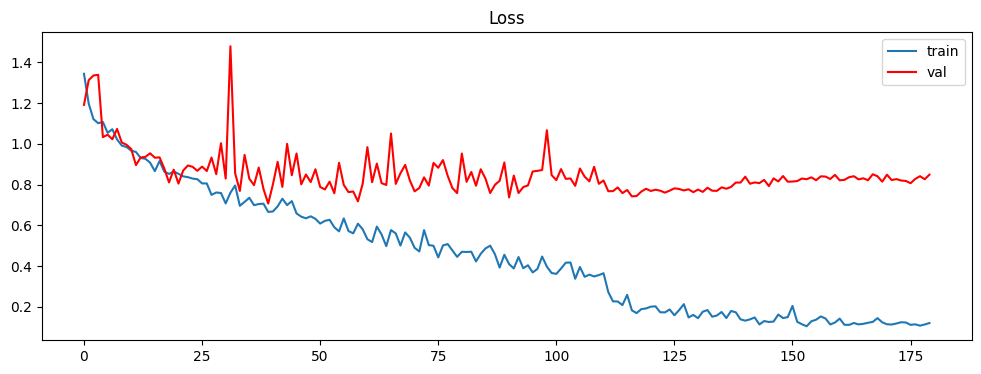

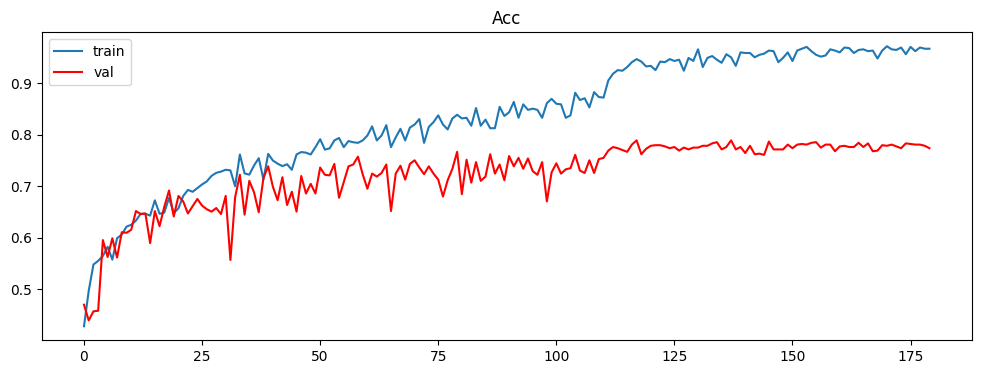

In [17]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()

In [ ]:
# save your well-trained state_dict of model
torch.save(model.state_dict(), 'NAME_OF_SUPERVISED_TRAINING_EXPERIMENT.pt')

finish training your classifier, next you should use this classifer to predict unlabel images with pseduo label.

## Step2: Use unlabeled data to enhance model performance

In [35]:
# load the trained classifier weights
ckpt = torch.load('NAME_OF_SUPERVISED_TRAINING_EXPERIMENT.pt')
model.load_state_dict(ckpt)

<All keys matched successfully>

In [36]:
# create a unlabeled data set list, we will use it later
unlabeled_set_list = []

for img in unlabeled_set:
    unlabeled_set_list.append(img)

print(len(unlabeled_set_list))

1713


### Define loss and optimizer

In [37]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

### Use the trained classifier to generates pseudo-labels of a dataset.

In [38]:
from torch.utils.data import ConcatDataset, DataLoader, Subset
from tqdm.auto import tqdm
import torch

###########################################################
#   You can adjust the threshold to get better result !   #
###########################################################
train_set = FlowerData('train_labeled_dataset.csv', mode='train', transform=transforms_train)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
def get_pseudo_labels(model, threshold=0.5):

    global unlabeled_set_list, train_set

    remove_index, index = [], 0

    model.eval()

    softmax = nn.Softmax(dim=-1)

    # Iterate over the dataset by batches.
    for img in tqdm(unlabeled_set_list):

        #####################################################################################
        #     TODO:                                                                         #
        #     1. Foward the data, Using torch.no_grad() accelerates the forward process     #
        #     2. obtain the probability distributions by applying softmax on logits         #
        #     3. Filter the data with threshold                                             #
        #     4. Combine the labeled training data with the pseudo-labeled data             #
        #        to construct a new training set. then removed                              #
        #     5. the unlabeled data from unlabeled_set_list                                 #
        #     hint: ConcatDataset                                                           #
        #####################################################################################
        with torch.no_grad():
            outputs = model.forward(img.view(-1,3,224,224).to(device))
            prob = softmax(outputs)

            # pseudo_labels = prob.argmax(dim=1)

            # for i,max_prob in enumerate(prob.max(dim=1).values):
            #   if max_prob >= threshold:
            #     pseudo_label = pseudo_labels[i].item()
            #     train_set = ConcatDataset([train_set,[(imgs[i],pseudo_label)]])
            #     remove_index.append(index)

            if prob.max() >= threshold:
              pseudo_label = prob.argmax().item()
              remove_index.append(index)
              train_set = ConcatDataset([train_set,[(img,pseudo_label)]])
        index+=1
        #####################################################################################
        #                           End of your code                                        #
        #####################################################################################

    remove_index.reverse()
    for i in remove_index:
        del unlabeled_set_list[i]

    print(f"[{len(train_set)-843}/1713] images have been labeled.")

    # # Turn off the eval mode.
    model.train()

### Train the model

Let's define train function.  

Use the **get_pseudo_labels** function to get the new training set, then construct a new data loader for training.

It will iterate input data 1 epoch and update model with optmizer.  

Finally, calculate mean loss and total accuracy.

In [39]:
import sys
sys.setrecursionlimit(1000000)
#########################################################################################################
#         You can adjust those hyper parameters like epochs or threshlod for training                   #
#########################################################################################################
n_epochs = 85
best_acc = 0

# from torch.optim.lr_scheduler import ExponentialLR
# scheduler = ExponentialLR(optimizer, gamma=0.94)
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=7,cooldown=5,min_lr=0.000000000000001)

torch.cuda.empty_cache()
# log_threshold = 0
threshold = 0.65

for epoch in range(n_epochs):

    torch.cuda.empty_cache()
    # log_threshold+=1
    # if threshold > 0.55 and log_threshold == 5:
    #   threshold -= 0.05
    #   log_threshold = 0
    #########################################################################################################
    #    TODO:                                                                                              #
    #    In each epoch, relabel the unlabeled dataset for semi-supervised learning.                         #
    #    1. Obtain pseudo-labels for unlabeled data using trained model.(use get_pseudo_labels function)    #
    #    2. Construct a new dataset and a data loader for training.                                         #
    #    You can try different way to use the get_pseudo_label function maybe will get the better result.   #                                  #
    #########################################################################################################
    get_pseudo_labels(model,threshold)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    #########################################################################################################
    #                                          End of your code                                             #
    #########################################################################################################

    # ---------- Training ----------
    model.train()

    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        imgs, labels = batch

        logits = model(imgs.to(device))

        loss = criterion(logits, labels.to(device))

        optimizer.zero_grad()

        loss.backward()

        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        train_loss.append(loss.item())
        train_accs.append(acc)

        torch.cuda.empty_cache()

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)




    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    model.eval()

    valid_loss = []
    valid_accs = []

    for batch in tqdm(valid_loader):

        imgs, labels = batch

        with torch.no_grad():
          logits = model(imgs.to(device))

        loss = criterion(logits, labels.to(device))

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc)

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_acc_last = valid_acc

    scheduler.step(valid_acc)

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    if valid_acc > best_acc:
        best_acc = valid_acc
        threshold = max(0.6,threshold * 0.95)
        torch.save(model.state_dict(), 'NAME_OF_SELF_TRAINING_EXPERIMENT.pt')
        print('[{:03d}/{:03d}] saving model with acc {:.3f}'.format(epoch + 1, n_epochs, best_acc))
    else:
        threshold = min(0.8,threshold * 1.05)
#########################################################################################################
#                               End of your code                                                        #
#########################################################################################################


  0%|          | 0/1713 [00:00<?, ?it/s]

[1498/1713] images have been labeled.


  0%|          | 0/74 [00:00<?, ?it/s]

[ Train | 001/085 ] loss = 0.52474, acc = 0.82103


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 001/085 ] loss = 0.79043, acc = 0.73247
[001/085] saving model with acc 0.732


  0%|          | 0/215 [00:00<?, ?it/s]

[1612/1713] images have been labeled.


  0%|          | 0/77 [00:00<?, ?it/s]

[ Train | 002/085 ] loss = 0.43493, acc = 0.84587


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 002/085 ] loss = 0.79271, acc = 0.74173
[002/085] saving model with acc 0.742


  0%|          | 0/101 [00:00<?, ?it/s]

[1680/1713] images have been labeled.


  0%|          | 0/79 [00:00<?, ?it/s]

[ Train | 003/085 ] loss = 0.41799, acc = 0.85033


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 003/085 ] loss = 0.89769, acc = 0.73765


  0%|          | 0/33 [00:00<?, ?it/s]

[1701/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 004/085 ] loss = 0.37887, acc = 0.86406


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 004/085 ] loss = 0.80562, acc = 0.76025
[004/085] saving model with acc 0.760


  0%|          | 0/12 [00:00<?, ?it/s]

[1707/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 005/085 ] loss = 0.35390, acc = 0.87116


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 005/085 ] loss = 0.85299, acc = 0.73595


  0%|          | 0/6 [00:00<?, ?it/s]

[1709/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 006/085 ] loss = 0.33680, acc = 0.87669


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 006/085 ] loss = 0.95247, acc = 0.71914


  0%|          | 0/4 [00:00<?, ?it/s]

[1711/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 007/085 ] loss = 0.31154, acc = 0.88579


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 007/085 ] loss = 0.91603, acc = 0.73539


  0%|          | 0/2 [00:00<?, ?it/s]

[1712/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 008/085 ] loss = 0.33903, acc = 0.87527


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 008/085 ] loss = 0.84459, acc = 0.75099


  0%|          | 0/1 [00:00<?, ?it/s]

[1712/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 009/085 ] loss = 0.27505, acc = 0.90586


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 009/085 ] loss = 0.81994, acc = 0.76427
[009/085] saving model with acc 0.764


  0%|          | 0/1 [00:00<?, ?it/s]

[1712/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 010/085 ] loss = 0.25400, acc = 0.90994


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 010/085 ] loss = 0.80383, acc = 0.76725
[010/085] saving model with acc 0.767


  0%|          | 0/1 [00:00<?, ?it/s]

[1712/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 011/085 ] loss = 0.27564, acc = 0.90308


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 011/085 ] loss = 0.82820, acc = 0.77943
[011/085] saving model with acc 0.779


  0%|          | 0/1 [00:00<?, ?it/s]

[1712/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 012/085 ] loss = 0.25558, acc = 0.91182


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 012/085 ] loss = 0.97750, acc = 0.72371


  0%|          | 0/1 [00:00<?, ?it/s]

[1712/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 013/085 ] loss = 0.24101, acc = 0.91892


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 013/085 ] loss = 0.92521, acc = 0.75909


  0%|          | 0/1 [00:00<?, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 014/085 ] loss = 0.21576, acc = 0.92249


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 014/085 ] loss = 0.86953, acc = 0.74636


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 015/085 ] loss = 0.23693, acc = 0.91641


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 015/085 ] loss = 0.85843, acc = 0.74691


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 016/085 ] loss = 0.23594, acc = 0.91384


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 016/085 ] loss = 1.01438, acc = 0.73077


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 017/085 ] loss = 0.21187, acc = 0.92919


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 017/085 ] loss = 1.08558, acc = 0.72608


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 018/085 ] loss = 0.19098, acc = 0.93343


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 018/085 ] loss = 0.83324, acc = 0.78693
[018/085] saving model with acc 0.787


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 019/085 ] loss = 0.18303, acc = 0.93443


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 019/085 ] loss = 0.89210, acc = 0.76720


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 020/085 ] loss = 0.19400, acc = 0.93231


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 020/085 ] loss = 1.07492, acc = 0.71329


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 021/085 ] loss = 0.17605, acc = 0.94018


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 021/085 ] loss = 1.02002, acc = 0.73132


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 022/085 ] loss = 0.20539, acc = 0.92796


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 022/085 ] loss = 0.95598, acc = 0.73595


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 023/085 ] loss = 0.21143, acc = 0.92260


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 023/085 ] loss = 1.04013, acc = 0.73710


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 024/085 ] loss = 0.16508, acc = 0.94872


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 024/085 ] loss = 0.90790, acc = 0.75331


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 025/085 ] loss = 0.18619, acc = 0.93549


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 025/085 ] loss = 0.98925, acc = 0.75391


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 026/085 ] loss = 0.16783, acc = 0.94336


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 026/085 ] loss = 0.88095, acc = 0.76257


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 027/085 ] loss = 0.10822, acc = 0.96211


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 027/085 ] loss = 0.79513, acc = 0.78979
[027/085] saving model with acc 0.790


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 028/085 ] loss = 0.09755, acc = 0.96680


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 028/085 ] loss = 0.82029, acc = 0.78748


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 029/085 ] loss = 0.08317, acc = 0.97617


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 029/085 ] loss = 0.80703, acc = 0.79266
[029/085] saving model with acc 0.793


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 030/085 ] loss = 0.08948, acc = 0.96864


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 030/085 ] loss = 0.81901, acc = 0.79211


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 031/085 ] loss = 0.07679, acc = 0.97617


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 031/085 ] loss = 0.80762, acc = 0.79905
[031/085] saving model with acc 0.799


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 032/085 ] loss = 0.07545, acc = 0.97260


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 032/085 ] loss = 0.82450, acc = 0.79095


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 033/085 ] loss = 0.08429, acc = 0.97143


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 033/085 ] loss = 0.82480, acc = 0.79327


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 034/085 ] loss = 0.08072, acc = 0.97695


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 034/085 ] loss = 0.83728, acc = 0.79095


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 035/085 ] loss = 0.07863, acc = 0.97333


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 035/085 ] loss = 0.83979, acc = 0.78632


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 036/085 ] loss = 0.06420, acc = 0.98237


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 036/085 ] loss = 0.85786, acc = 0.78053


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 037/085 ] loss = 0.05371, acc = 0.98477


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 037/085 ] loss = 0.85451, acc = 0.77938


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 038/085 ] loss = 0.07760, acc = 0.97372


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 038/085 ] loss = 0.85213, acc = 0.78979


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 039/085 ] loss = 0.06714, acc = 0.98047


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 039/085 ] loss = 0.86038, acc = 0.78516


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 040/085 ] loss = 0.07204, acc = 0.97533


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 040/085 ] loss = 0.85660, acc = 0.79327


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 041/085 ] loss = 0.07286, acc = 0.97500


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 041/085 ] loss = 0.87075, acc = 0.78401


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 042/085 ] loss = 0.04595, acc = 0.98828


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 042/085 ] loss = 0.85733, acc = 0.78401


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 043/085 ] loss = 0.06003, acc = 0.98359


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 043/085 ] loss = 0.86259, acc = 0.78979


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 044/085 ] loss = 0.05911, acc = 0.98080


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 044/085 ] loss = 0.86145, acc = 0.78516


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 045/085 ] loss = 0.05514, acc = 0.98588


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 045/085 ] loss = 0.84367, acc = 0.79674


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 046/085 ] loss = 0.05359, acc = 0.98320


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 046/085 ] loss = 0.83334, acc = 0.79789


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 047/085 ] loss = 0.06573, acc = 0.98002


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 047/085 ] loss = 0.86773, acc = 0.78864


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 048/085 ] loss = 0.05218, acc = 0.98438


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 048/085 ] loss = 0.87232, acc = 0.78632


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 049/085 ] loss = 0.06095, acc = 0.98242


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 049/085 ] loss = 0.86336, acc = 0.79327


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 050/085 ] loss = 0.05782, acc = 0.98086


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 050/085 ] loss = 0.84876, acc = 0.79674


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 051/085 ] loss = 0.05805, acc = 0.98242


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 051/085 ] loss = 0.84721, acc = 0.78979


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 052/085 ] loss = 0.05510, acc = 0.98153


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 052/085 ] loss = 0.86602, acc = 0.79789


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 053/085 ] loss = 0.05604, acc = 0.98153


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 053/085 ] loss = 0.85195, acc = 0.79095


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 054/085 ] loss = 0.06110, acc = 0.98125


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 054/085 ] loss = 0.85381, acc = 0.79442


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 055/085 ] loss = 0.03841, acc = 0.98862


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 055/085 ] loss = 0.86692, acc = 0.78979


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 056/085 ] loss = 0.06607, acc = 0.97930


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 056/085 ] loss = 0.88170, acc = 0.78632


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 057/085 ] loss = 0.06539, acc = 0.98080


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 057/085 ] loss = 0.85634, acc = 0.78979


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 058/085 ] loss = 0.04729, acc = 0.98594


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 058/085 ] loss = 0.86801, acc = 0.79211


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 059/085 ] loss = 0.05729, acc = 0.98203


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 059/085 ] loss = 0.86347, acc = 0.79095


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 060/085 ] loss = 0.05478, acc = 0.98544


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 060/085 ] loss = 0.88842, acc = 0.78748


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 061/085 ] loss = 0.05360, acc = 0.98672


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 061/085 ] loss = 0.88560, acc = 0.78285


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 062/085 ] loss = 0.06418, acc = 0.97768


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 062/085 ] loss = 0.86098, acc = 0.78979


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 063/085 ] loss = 0.05294, acc = 0.98516


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 063/085 ] loss = 0.87542, acc = 0.78516


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 064/085 ] loss = 0.05661, acc = 0.98086


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 064/085 ] loss = 0.86314, acc = 0.79674


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 065/085 ] loss = 0.05785, acc = 0.98276


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 065/085 ] loss = 0.86381, acc = 0.78516


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 066/085 ] loss = 0.06307, acc = 0.98281


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 066/085 ] loss = 0.86631, acc = 0.78979


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 067/085 ] loss = 0.04978, acc = 0.98438


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 067/085 ] loss = 0.87477, acc = 0.78864


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 068/085 ] loss = 0.05622, acc = 0.98002


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 068/085 ] loss = 0.86957, acc = 0.78748


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 069/085 ] loss = 0.05351, acc = 0.98359


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 069/085 ] loss = 0.86383, acc = 0.78748


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 070/085 ] loss = 0.04947, acc = 0.98438


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 070/085 ] loss = 0.87186, acc = 0.79327


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 071/085 ] loss = 0.05616, acc = 0.98281


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 071/085 ] loss = 0.85336, acc = 0.79327


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 072/085 ] loss = 0.06757, acc = 0.97840


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 072/085 ] loss = 0.88320, acc = 0.78632


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 073/085 ] loss = 0.06045, acc = 0.98008


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 073/085 ] loss = 0.85866, acc = 0.79211


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 074/085 ] loss = 0.05129, acc = 0.98359


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 074/085 ] loss = 0.85773, acc = 0.79211


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 075/085 ] loss = 0.04969, acc = 0.98588


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 075/085 ] loss = 0.90394, acc = 0.77243


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 076/085 ] loss = 0.05536, acc = 0.98281


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 076/085 ] loss = 0.84920, acc = 0.79558


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 077/085 ] loss = 0.06483, acc = 0.97852


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 077/085 ] loss = 0.88098, acc = 0.78285


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 078/085 ] loss = 0.06046, acc = 0.97963


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 078/085 ] loss = 0.85467, acc = 0.79327


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 079/085 ] loss = 0.05968, acc = 0.98002


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 079/085 ] loss = 0.84517, acc = 0.80252
[079/085] saving model with acc 0.803


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 080/085 ] loss = 0.05821, acc = 0.98036


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 080/085 ] loss = 0.87304, acc = 0.78169


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 081/085 ] loss = 0.05806, acc = 0.98359


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 081/085 ] loss = 0.85252, acc = 0.79327


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 082/085 ] loss = 0.05962, acc = 0.98237


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 082/085 ] loss = 0.87309, acc = 0.78632


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 083/085 ] loss = 0.05885, acc = 0.98281


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 083/085 ] loss = 0.85040, acc = 0.79095


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 084/085 ] loss = 0.06418, acc = 0.97891


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 084/085 ] loss = 0.86630, acc = 0.78516


0it [00:00, ?it/s]

[1713/1713] images have been labeled.


  0%|          | 0/80 [00:00<?, ?it/s]

[ Train | 085/085 ] loss = 0.05455, acc = 0.98242


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 085/085 ] loss = 0.87222, acc = 0.78285


In [45]:
# save your well-trained state_dict of model
torch.save(model.state_dict(), 'NAME_OF_SELF_TRAINING_EXPERIMENT.pt')

### Predict Result

Predict the labesl based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/e304bb12c8a84e5c9c1b27a6c3bd4026).

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 50% dataset and publish this result to leaderboard.

---

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/t/e304bb12c8a84e5c9c1b27a6c3bd4026)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中50%資料的正確率

In [41]:
# if you wanna load previous best model
ckpt = torch.load('NAME_OF_SELF_TRAINING_EXPERIMENT.pt')
model.load_state_dict(ckpt)

<All keys matched successfully>

In [42]:
test_set = FlowerData('test.csv', mode='test', transform=transforms_test)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [43]:
def predict(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for images in input_data:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
    return output_list

In [44]:
idx = 0
output_csv = predict(test_loader, model)
with open('result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'label'])
    writer.writeheader()
    for result in output_csv:
        file_path = test_set.data_list[idx].replace(data_folder + '/', '')
        writer.writerow({'file_path':file_path, 'label':result})
        idx += 1